# Topic Clustering Using Latent Dirchlet Allocation

**Set path:**

In [8]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_RESULTS = os.path.join(PATH, 'results/topics')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'
sys.path.append(os.path.join(PATH, 'src'))
TRAIN_SIZE = 0.15
START = '2020_02_23'
END = '2020_07_18'

**Load libraries:**

In [9]:
import numpy as np
import pandas as pd
from twitter_tools.utils import read_files
from twitter_tools.evaluation import topics as evaluation
import pickle
import json
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import gc
from operator import itemgetter
from itertools import product
from pprint import pprint
from functools import partial
from dask.diagnostics import ProgressBar
tqdm.pandas()


import pyLDAvis
import pyLDAvis.gensim

from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel, HdpModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.wrappers import ldamallet
from gensim.test.utils import datapath
from sklearn.model_selection import StratifiedShuffleSplit

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


**Load stopwords**

In [10]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        stopwords.append(line.strip('\n'))
stopwords.append('mieć')

dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

### Read the data:
Use a preprocessing function which removes IDs determined to be outliers by the previous analysis, tokenizes the lemmatized data and removes stopwords.

In [11]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))
PATH_PREPROCESSED = os.path.join(PATH, 'data/clean')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'

#filter function:
def filter_fun(df, drop_users, drop_tweets):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

In [12]:
data = pd.DataFrame()
id2word = Dictionary()
for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
    dat.drop_duplicates(subset = ['lemmatized'], inplace = True)
    dat.lemmatized = dat.lemmatized.apply(lambda x: [w for w in x.split() if w not in stopwords])
    id2word.add_documents(dat.lemmatized.tolist())
    dat = dat.groupby('source').apply(lambda x: x.sample(frac = TRAIN_SIZE, random_state = 1234))
    data = data.append(dat)
    gc.collect()
data.drop_duplicates(subset = ['tokenized'], inplace = True)

### Prepare the training data:

In [46]:
text = data['lemmatized'].tolist()
corpus = [id2word.doc2bow(t) for t in text]

### Define helper functions:

In [7]:
def grid_search_lda(model, params, corpus, text, id2word, save_models = None, 
                    train_size = 0.5, split_seed = 1234, perplexity = True, **kwargs):

    #prepare search space:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    for i, pars in tqdm(enumerate(grid)):
        #train
        lda = model(corpus = corpus, id2word = id2word, 
                           num_topics = pars['k'], **kwargs)
        
        #eval
        if perplexity:
            grid[i]['perplexity'] = lda.log_perplexity(corpus)
        coherence = CoherenceModel(model = lda, texts  = text, dictionary=id2word, coherence='c_v')
        grid[i]['coherence'] = coherence.get_coherence() 
        
        #save
        if save_models is not None:
            lda.save(os.path.join(save_models, 'lda_' + str(pars['k'])))
        
        del(lda)
        gc.collect()
    return grid

## LDA-Mallet

## Grid Search

In [17]:
PATH_MODELS = os.path.join(PATH_RESULTS, 'mallet')
PATH_PARAMS = os.path.join(PATH_MODELS, 'params.json')
PATH_MALLET = '/home/piotr/nlp/Mallet/bin/mallet'
if os.path.isfile(PATH_PARAMS):
    comparison = json.load(open(PATH_PARAMS, 'r'))
else:
    params = {'k':range(3, 25, 2)}
    comparison = grid_search_lda(model = ldamallet.LdaMallet, params = params, corpus = corpus, text = text, 
                                 save_models = PATH_MODELS, id2word = id2word, 
                                 perplexity = False, mallet_path = PATH_MALLET, workers = 4)
    json.dump(comparison, open(PATH_PARAMS, 'w'))

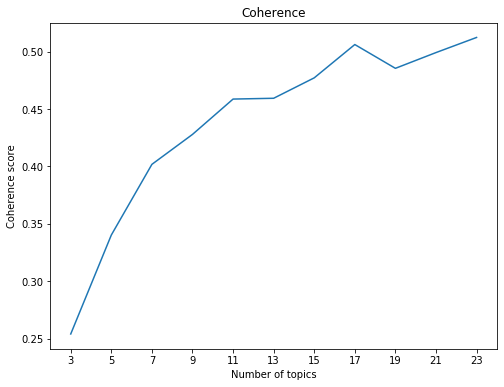

In [23]:
pd.DataFrame(comparison).plot('k','coherence', title = 'Coherence', legend = False, figsize = (8, 6))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.xticks(range(3, 25, 2))
plt.show()

#### Load the best model:

In [5]:
PATH_MODELS = os.path.join(PATH, 'results/topics/mallet')
mallet = ldamallet.LdaMallet.load(os.path.join(PATH_MODELS, 'lda_21'))
mallet = ldamallet.malletmodel2ldamodel(mallet)

### Evaluation

#### Visualize topic map using `LDAvis`

In [61]:
#visualize topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet, corpus, id2word)
pyLDAvis.save_html(vis, os.path.join(PATH_MODELS, 'mallet_vis.html'))
vis

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.162880  0.056538       1        1  4.931753
10     0.109804  0.070795       2        1  4.928522
3      0.159451 -0.149056       3        1  4.884810
16     0.102817  0.027463       4        1  4.874192
15     0.132748 -0.139103       5        1  4.849193
12     0.156254  0.118137       6        1  4.806687
6     -0.061508 -0.142664       7        1  4.787021
2      0.073004  0.085840       8        1  4.778422
13     0.042740 -0.023921       9        1  4.776083
9      0.097532  0.077777      10        1  4.770822
7      0.047959  0.034218      11        1  4.768450
11    -0.030972 -0.214781      12        1  4.758063
19    -0.203516 -0.140956      13        1  4.735100
18     0.092192 -0.085140      14        1  4.733420
5     -0.173446  0.150744      15        1  4.712210
0     -0.148752 -0.157554      16        1  4.685718
8      0.006688  0.217110      17        1  4.683976
17    -0.233382  0.121722      18        1  4.663606
4     -0.204192  0.039931      19        1  4.636059
20    -0.121376  0.074995      20        1  4.634068
14    -0.006925 -0.022095      21        1  4.601822, topic_info=           Term          Freq         Total Category  logprob  loglift
307      wybory  36957.000000  36957.000000  Default  30.0000  30.0000
44       polska  42147.000000  42147.000000  Default  29.0000  29.0000
97         duda  33685.000000  33685.000000  Default  28.0000  28.0000
58     wiedzieć  30210.000000  30210.000000  Default  27.0000  27.0000
193   prezydent  29668.000000  29668.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1135      lubić   2769.516991   5108.489981  Topic21  -4.7755   2.4665
497    nadzieja   2694.719817   5179.124136  Topic21  -4.8029   2.4254
951   niedziela   1928.554168   2956.994913  Topic21  -5.1374   2.6513
809       pełny   1908.338715   3067.391023  Topic21  -5.1480   2.6041
856     trzymać   1741.561232   3794.657145  Topic21  -5.2394   2.2999

[1680 rows x 6 columns], token_table=        Topic      Freq       Term
term                              
4860        4  0.004397    aborcja
4860       13  0.995247    aborcja
198253      9  1.002211   actimelk
139395     10  0.976264     adolfa
35958       9  1.002211  adresatka
...       ...       ...        ...
17497       4  1.000213  żywiołowy
646        12  0.134082        żyć
646        13  0.622787        żyć
646        15  0.243171        żyć
191683     19  1.000622  żółkiewka

[2534 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 4, 17, 16, 13, 7, 3, 14, 10, 8, 12, 20, 19, 6, 1, 9, 18, 5, 21, 15])

In [13]:
topic_dict = {1:'coronavirus',
          2:'finance',
          3:'country',
          4:'rule of law',
          5:'history/ww2',
          6:'elections',
          7:'political parties',
          8:'lockdown',
          9:'voting',
          10:'justice/rule of law',
          11:'media',
          12:'religion',
          13:'unk',
          14:'presidential candidates',
          15:'unk2',
          16:'aggresion(?)',
          17:'unk3',
          18:'verbs',
          19:'writing/reading',
          20:'staying at home (?)',
          21:'greetings'}
json.dump(topic_dict, open(os.path.join(PATH_MODELS, 'best_model_topic_dict.json'), 'w'))

#### Predict topics for the entire corpus

In [14]:
PATH_TOPICS = os.path.join(PATH_MODELS, 'best_model_topics.json')
if os.path.isfile(PATH_TOPICS):
    topic_map = json.load(open(PATH_TOPICS, 'r'))
else:
    topic_map = dict()
    for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = ff, method = 'pandas')):
        dat.drop_duplicates(subset = ['lemmatized'], inplace = True) #drop duplicates
        lemmas = dat.lemmatized.apply(lambda x: [w for w in x.split() if w not in stopwords]).tolist() #get list
        texts = [id2word.doc2bow(t) for t in lemmas] #get bow representation
        topics = evaluation.lda_predict(mallet, texts) #predict topics
        topic_map.update(dict(zip(dat.lemmatized.tolist(), topics))) #store topics
    json.dump(topic_map, open(PATH_TOPICS, 'w'))

#### Visualize temporal and party distribution:
- note that by mistake each topic in the plots below corresponds with the topic from previous graph - 1 (i.e 1 in previous is 0 below, etc). Will be fixed later

In [15]:
data['lemmatized'] = data['lemmatized'].progress_apply(lambda x: " ".join(x))
data = evaluation.map_clusters(data, topic_map, 'lemmatized')
data['cluster'] += 1

/home/piotr/projects/twitter/src/twitter_tools/evaluation/topics.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = data['cluster'].map(topic_dict)


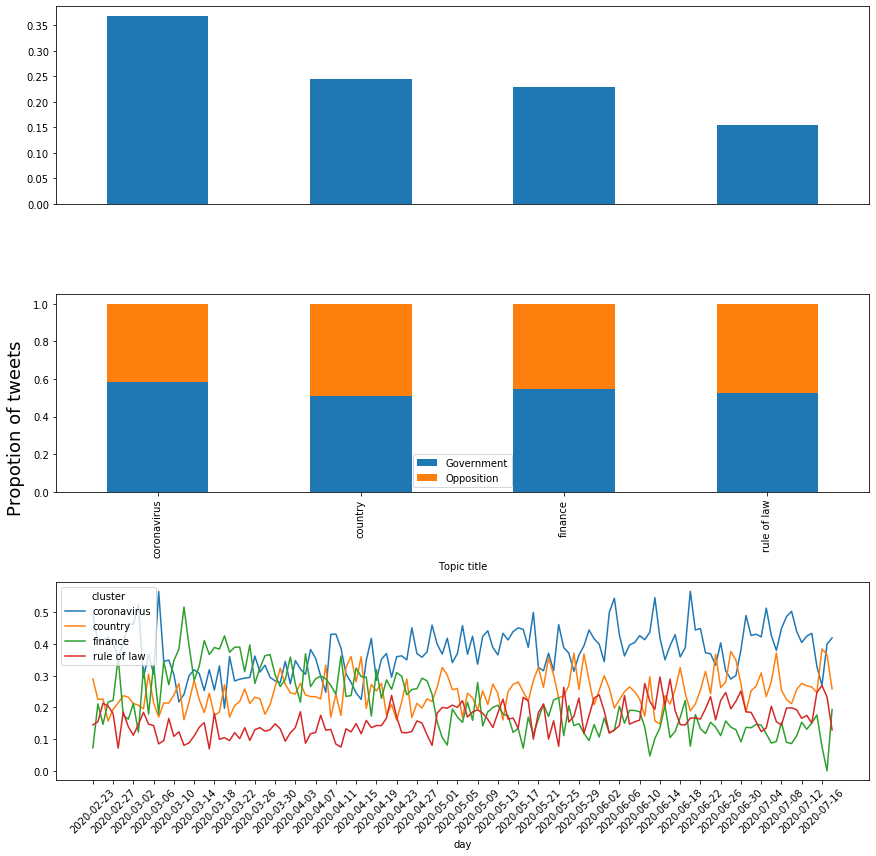

In [35]:
evaluation.plot_dists(data, figsize = (12, 12), topic_dict = topic_dict, 
                                     topic_subset = [1, 2, 3, 4])

/home/piotr/projects/twitter/src/twitter_tools/evaluation/topics.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = data['cluster'].map(topic_dict)


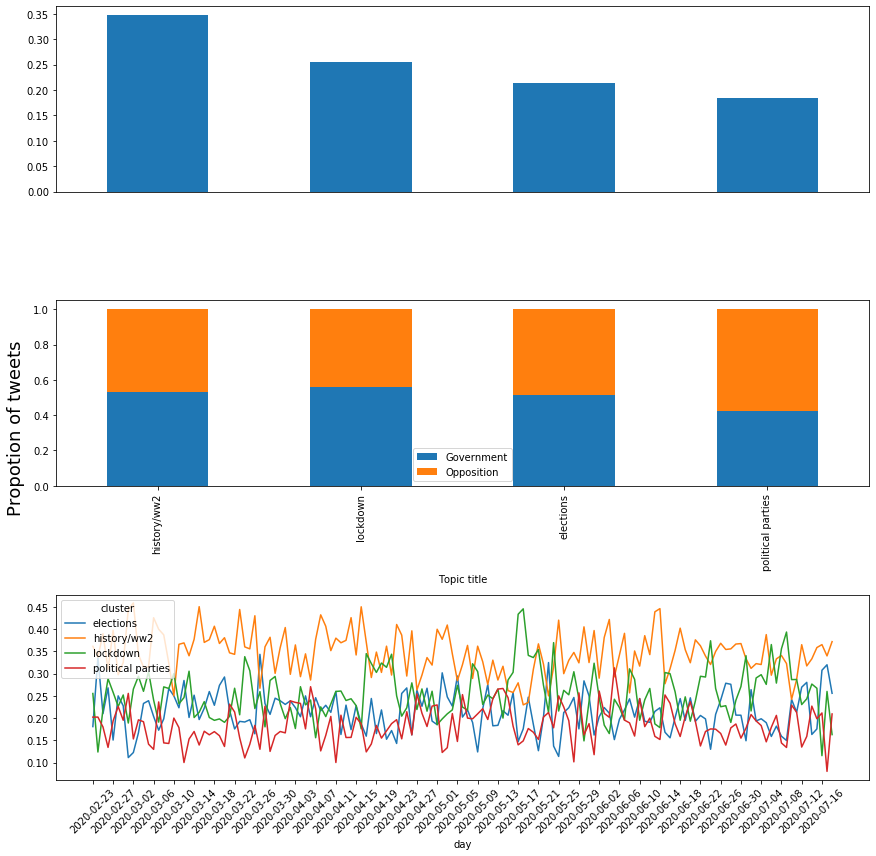

In [36]:
evaluation.plot_dists(data, figsize = (12, 12), topic_dict = topic_dict, 
                                     topic_subset = [5, 6, 7, 8])

/home/piotr/projects/twitter/src/twitter_tools/evaluation/topics.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = data['cluster'].map(topic_dict)


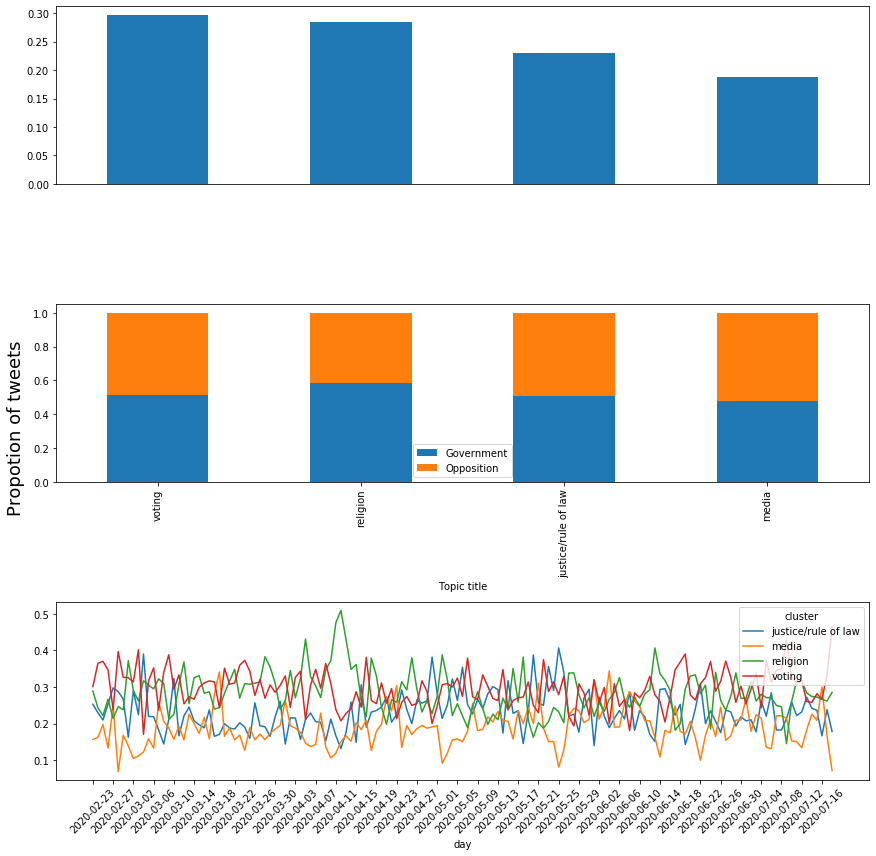

In [37]:
evaluation.plot_dists(data, figsize = (12, 12), topic_dict = topic_dict, 
                                     topic_subset = [9, 10, 11, 12])

/home/piotr/projects/twitter/src/twitter_tools/evaluation/topics.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = data['cluster'].map(topic_dict)


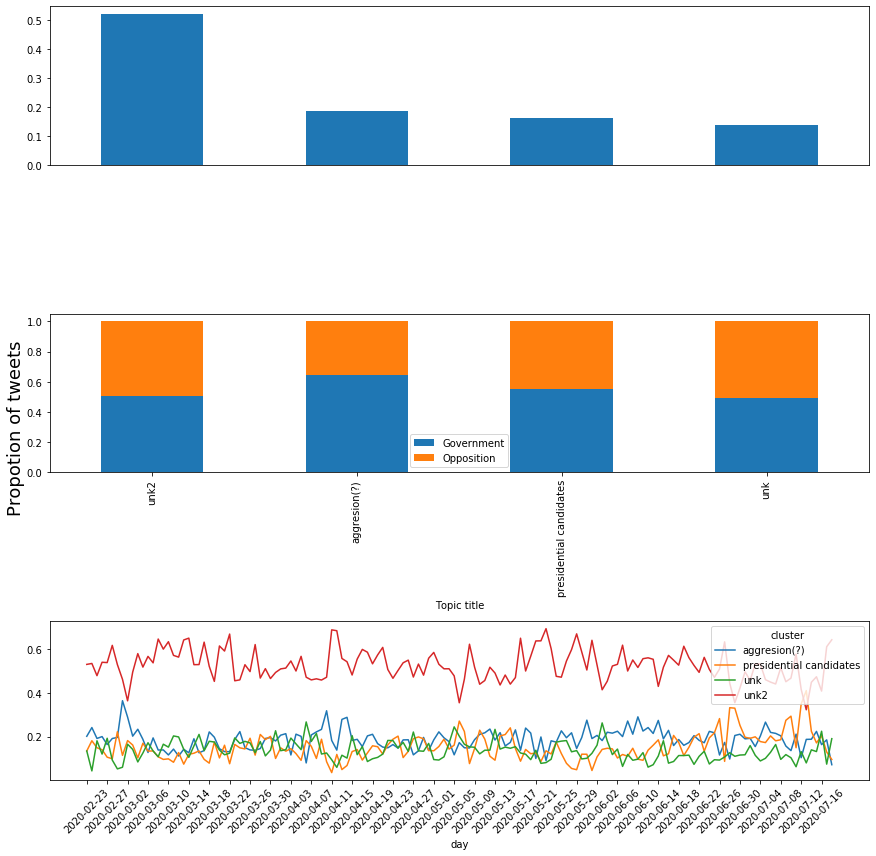

In [38]:
evaluation.plot_dists(data, figsize = (12, 12), topic_dict = topic_dict, 
                                     topic_subset = [13, 14, 15, 16])

/home/piotr/projects/twitter/src/twitter_tools/evaluation/topics.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = data['cluster'].map(topic_dict)


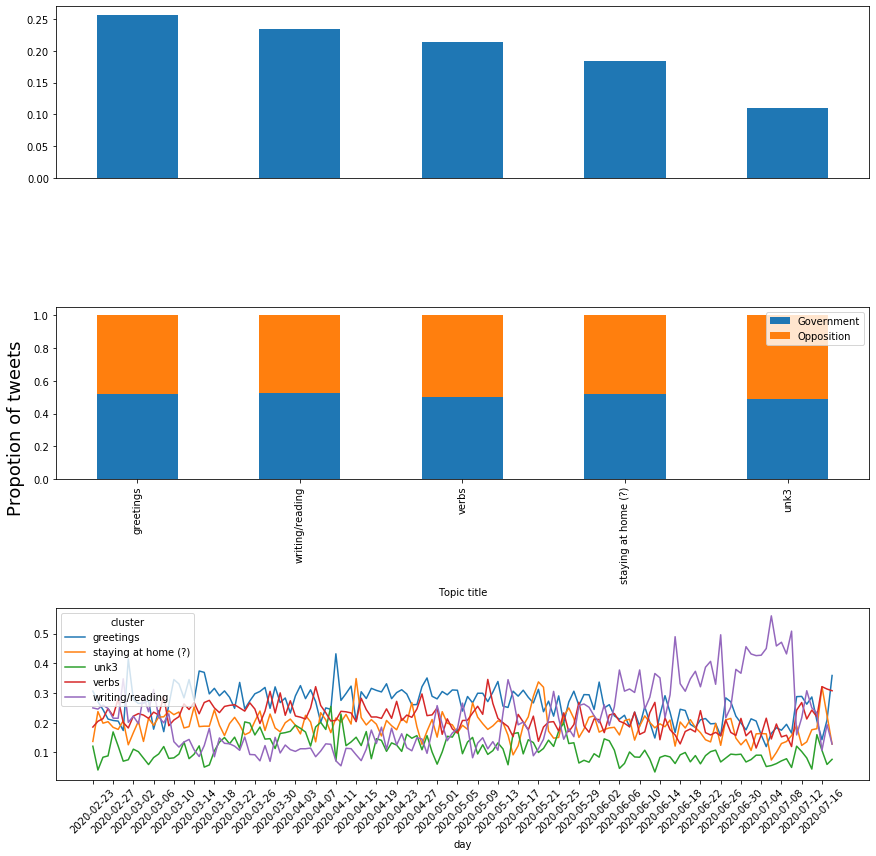

In [39]:
evaluation.plot_dists(data, figsize = (12, 12), topic_dict = topic_dict, 
                                     topic_subset = [17, 18, 19, 20, 21])